In [10]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from model import LightningUNET
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import random
from torchmetrics import JaccardIndex

datapath = '/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/GOES-16/'
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 16
LEARNING_RATE = 0.0001
EPOCHS = 1000
DATALOADER_WORKERS = 10

In [11]:
channel_mins = torch.tensor([26.8503,  0.1685, -8.2685, -1.4102, -1.1436, -0.1486,  0.0375,  0.2940,
         0.7091,  1.0280,  2.7341, 10.9818,  7.9130, 10.6544, 14.0237, 17.8245])
channel_maxs = torch.tensor([ 804.0361, 4095.0000,  373.1670,   79.2232,   94.8480,   29.7895,
          19.2759,    7.1074,   17.2302,   27.8833,  103.7081,   78.4874,
         159.9617,  175.4634,  178.8900,  132.4386])

In [12]:
# ABI Chip Loader
class AbiChipDataset(Dataset):
    def __init__(self, chip_paths):
        self.chip_paths = chip_paths

    def __len__(self):
        return len(self.chip_paths)

    def __getitem__(self, idx):
        chip = np.load(self.chip_paths[idx], allow_pickle=True)
        image = torch.from_numpy(chip['chip'])
        image = (image - channel_mins) / (channel_maxs - channel_mins)
        image = image.permute(2, 0, 1).float()
        mask = torch.from_numpy(chip['data'].item()['Cloud_mask_binary']).unsqueeze(0).float()

        return (image, mask)

In [13]:
class AbiDataModule(pl.LightningDataModule):
    def __init__(self, chip_dir = datapath, batch_size = BATCH_SIZE):
        super().__init__()
        self.chip_dir = chip_dir
        self.batch_size = batch_size

    def setup(self, stage):
        total_chips = glob.glob(self.chip_dir + "*.npz")
        train_idx = int(len(total_chips) * 0.8)
        val_idx = int(len(total_chips) * 0.9)
        self.train_dataset = AbiChipDataset(total_chips[:train_idx])
        self.val_dataset = AbiChipDataset(total_chips[train_idx:val_idx])
        self.test_dataset = AbiChipDataset(total_chips[val_idx:])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=DATALOADER_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=DATALOADER_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=DATALOADER_WORKERS)

In [16]:
pl.seed_everything(42, workers=True)

unet = LightningUNET(in_channels=IMG_CHANNELS, classes=1, learning_rate=LEARNING_RATE)
# unet = LightningUNET.load_from_checkpoint("/explore/nobackup/projects/pix4dcloud/szhang16/checkpoints/lightning_logs/version_39080930/checkpoints/epoch=7-step=2400.ckpt", in_channels=16)

# lr_scheduler = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
early_stopping = pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min")

datamodule = AbiDataModule(datapath, BATCH_SIZE)

trainer = pl.Trainer(
    deterministic=True,
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    callbacks=[early_stopping],
    default_root_dir="/explore/nobackup/projects/pix4dcloud/szhang16/checkpoints/"
)

trainer.fit(model=unet, datamodule=datamodule)

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | UNET               | 31.0 M
1 | iou       | BinaryJaccardIndex | 0     
2 | ce_loss   | BCEWithLogitsLoss  | 0     
3 | dice_loss | DiceLoss           | 0     
-------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.187   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0:  89%|████████▉ | 600/675 [01:28<00:11,  6.79it/s, loss=0.427, v_num=3.91e+7]
Validation: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▉ | 600/675 [01:28<00:11,  6.75it/s, loss=0.406, v_num=3.91e+7]
Validation: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 600/675 [01:28<00:11,  6.77it/s, loss=0.377, v_num=3.91e+7]
Validation: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▉ | 600/675 [01:28<00:11,  6.77it/s, loss=0.376, v_num=3.91e+7]
Validation: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▉ | 600/675 [01:28<00:11,  6.75it/s, loss=0.362, v_num=3.91e+7]
Validation: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▉ | 600/675 [01:28<00:11,  6.76it/s, loss=0.355, v_num=3.91e+7]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 675/675 [01:34<00:00,  7.11it/s, loss=0.355, v_num=3.91e+7]


In [15]:
trainer.test(model=unet, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 75/75 [00:04<00:00, 16.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.30032041668891907    │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.30032041668891907}]

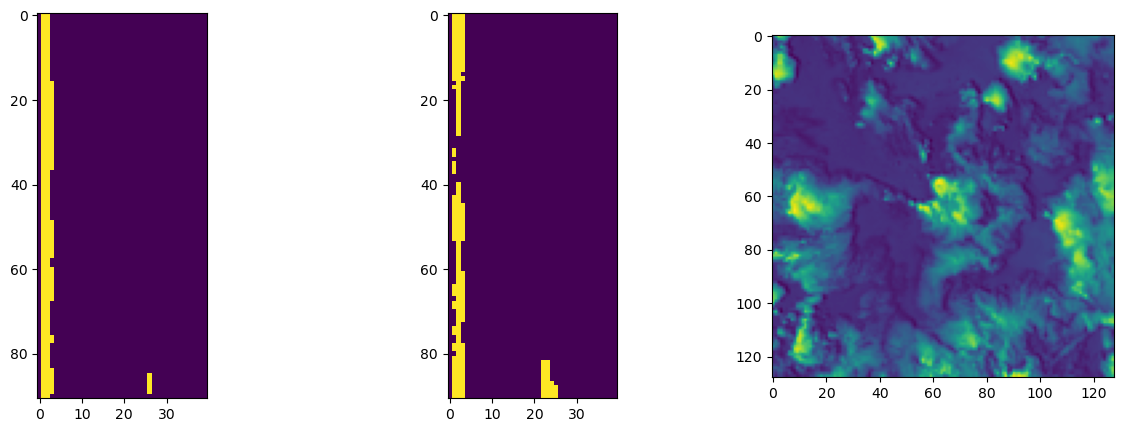

2019-356-72726_7228-2438-7280.npz
tensor(0.5190)
tensor(0.2887, grad_fn=<AddBackward0>)


In [7]:
filename = "2019-356-72726_7228-2438-7280.npz"
sample_chip = np.load(f"/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/GOES-16/{filename}", allow_pickle=True)
data = torch.from_numpy(sample_chip['chip'])
pred = unet.forward(data.permute(2, 0, 1).unsqueeze(0))
fig, axs = plt.subplots(1,3, figsize=(15, 5))


truth = torch.from_numpy(sample_chip['data'].item()['Cloud_mask_binary']).unsqueeze(0).unsqueeze(0).float()


ce = unet.ce_loss(pred, truth)
dice = unet.dice_loss(pred, truth)
loss = unet.dice_weight * dice + (1 - unet.dice_weight) * ce
pred = torch.sigmoid(pred) > 0.5


pred = pred.squeeze()
truth = truth.squeeze()
axs[0].imshow(pred)
axs[1].imshow(truth)
axs[2].imshow(data[:, :, 2])
plt.show()
print(filename)
print(unet.iou(pred, truth))
print(loss)

In [8]:
trainer.save_checkpoint("/explore/nobackup/projects/pix4dcloud/szhang16/checkpoints/july21training-early.ckpt")